In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="7"

Fri Jan 26 20:48:55 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   51C    P0    81W / 300W |   8299MiB / 80994MiB |     24%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4_quantize200_exp-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


In [8]:
path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
# warm start
for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
    model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
print('done')

done


### Dataset

In [9]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [10]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [11]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [12]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

def exponential(start_value, end_value, current_step, start_step, end_step, alpha):
    # 입력 검증
    if end_step == start_step:
        raise ValueError("end_step must be greater than start_step")
    
    # 경계 조건 처리
    if current_step <= start_step:
        return start_value
    elif current_step >= end_step:
        return end_value
    
    # 변화율 계산
    total_steps = end_step - start_step
    step_ratio = (current_step - start_step) / total_steps

    # alpha에 따른 지수적 변화 계산
    if alpha < 0:
        # -1에 가까울수록 처음에 가파르고 나중에 완만
        modified_ratio = 1 - (1 - step_ratio) ** (1 + abs(alpha))
    elif alpha > 0:
        # 1에 가까울수록 처음에 완만하고 나중에 가파름
        modified_ratio = step_ratio ** (1 + alpha)
    else:  # alpha == 0
        # alpha가 0이면 선형
        modified_ratio = step_ratio

    # 최종 값 계산
    return start_value + (end_value - start_value) * modified_ratio

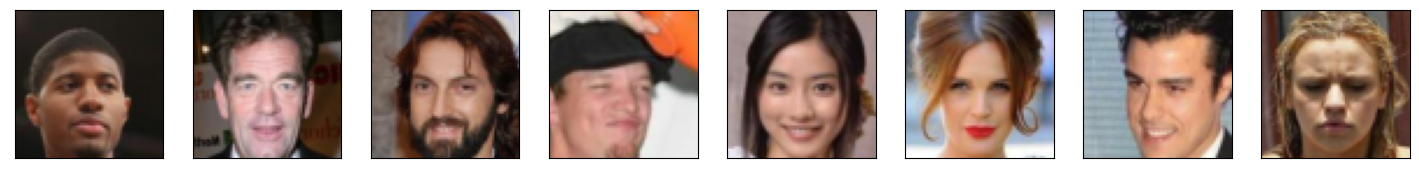

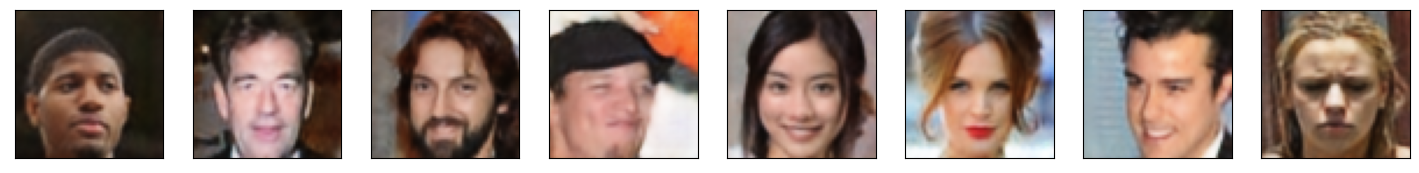

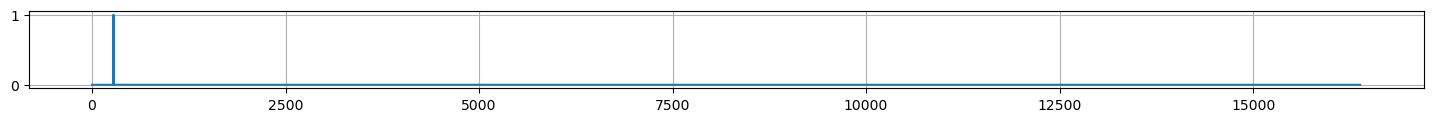

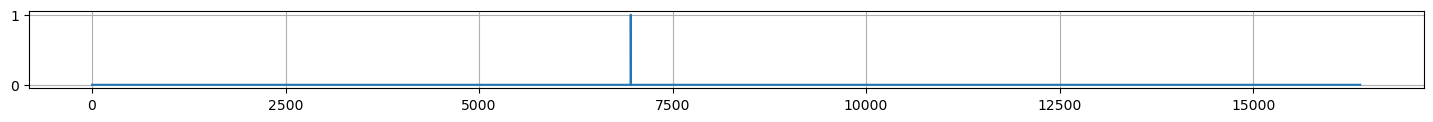

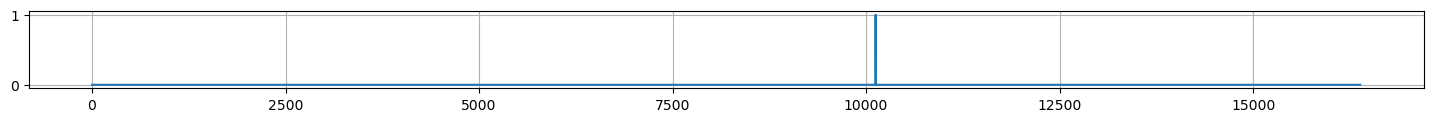

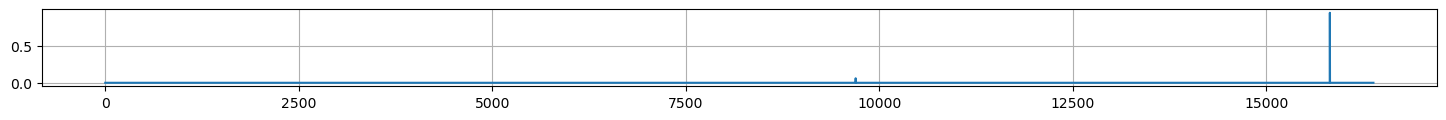

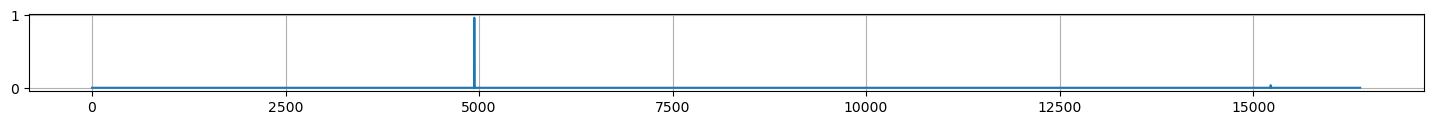

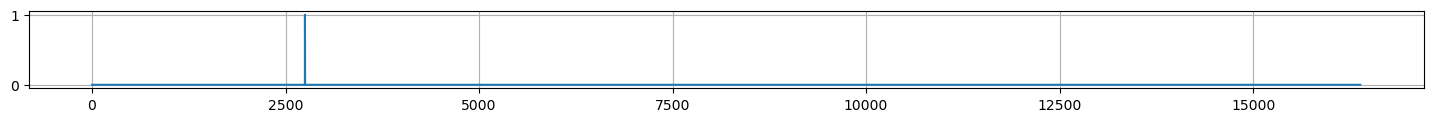

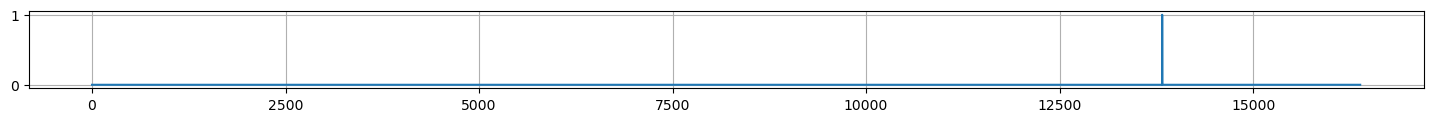

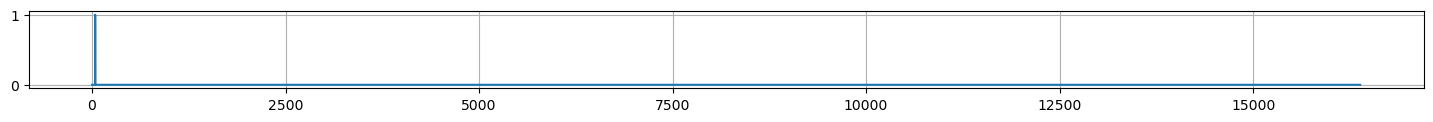

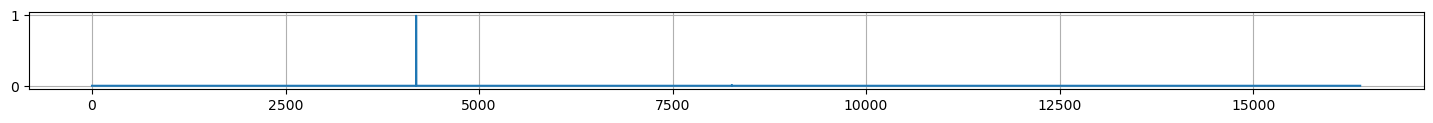

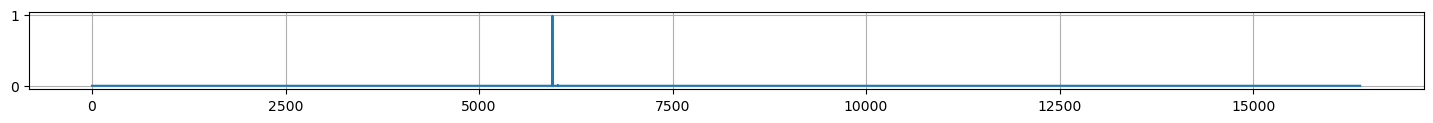

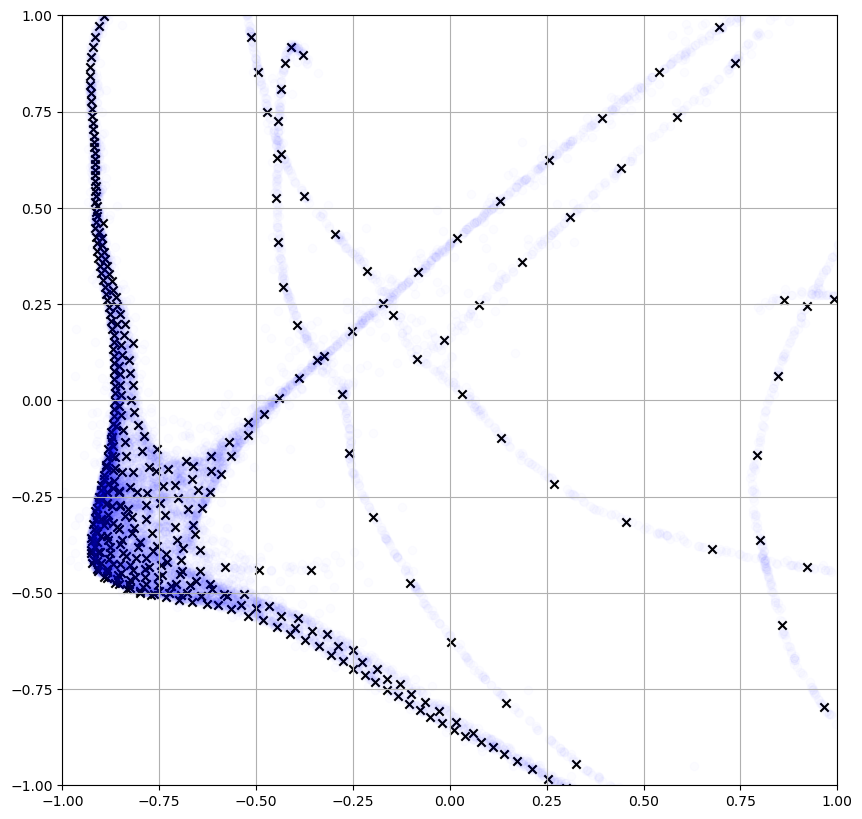

1001
lse_loss -406.08367919921875
commit_loss 7.248948531923816e-05
recon_loss 0.0007402733899652958
1002
lse_loss -407.4002990722656
commit_loss 7.311760418815538e-05
recon_loss 0.0007990025915205479
1003
lse_loss -405.9633483886719
commit_loss 6.917168502695858e-05
recon_loss 0.0007276333635672927
1004
lse_loss -410.9823913574219
commit_loss 7.278069097083062e-05
recon_loss 0.0008202441968023777
1005
lse_loss -404.4277038574219
commit_loss 7.136679050745443e-05
recon_loss 0.0008077846723608673
1006
lse_loss -402.1752014160156
commit_loss 7.38777598598972e-05
recon_loss 0.0007722009904682636
1007
lse_loss -412.0818786621094
commit_loss 7.126276614144444e-05
recon_loss 0.0007725300965830684
1008
lse_loss -410.151611328125
commit_loss 6.897431740071625e-05
recon_loss 0.0006937779253348708
1009
lse_loss -408.9205627441406
commit_loss 7.136461499612778e-05
recon_loss 0.0007200274849310517
1010
lse_loss -408.9012756347656
commit_loss 7.433141581714153e-05
recon_loss 0.0007652798667550087
1

1085
lse_loss -413.4306640625
commit_loss 7.41331823519431e-05
recon_loss 0.0007030698470771313
1086
lse_loss -404.53369140625
commit_loss 7.403452036669478e-05
recon_loss 0.0007360639865510166
1087
lse_loss -404.3777160644531
commit_loss 7.47709273127839e-05
recon_loss 0.000758560374379158
1088
lse_loss -402.5439758300781
commit_loss 7.32038970454596e-05
recon_loss 0.0007349810330197215
1089
lse_loss -405.9019775390625
commit_loss 7.080619980115443e-05
recon_loss 0.0007822626503184438
1090
lse_loss -398.7455139160156
commit_loss 7.085720426402986e-05
recon_loss 0.0007027591345831752
1091
lse_loss -408.9976501464844
commit_loss 7.126858690753579e-05
recon_loss 0.0007304970058612525
1092
lse_loss -406.82403564453125
commit_loss 7.424934301525354e-05
recon_loss 0.0008815055480226874
1093
lse_loss -411.8119201660156
commit_loss 7.447863754350692e-05
recon_loss 0.0007344086188822985
1094
lse_loss -408.6510925292969
commit_loss 7.351304520852864e-05
recon_loss 0.0006855117972008884
1095
lse

lse_loss -401.4291076660156
commit_loss 7.059516792651266e-05
recon_loss 0.0007849598187021911
1170
lse_loss -407.0711669921875
commit_loss 7.091983570717275e-05
recon_loss 0.0007356422720476985
1171
lse_loss -408.32244873046875
commit_loss 7.783319597365335e-05
recon_loss 0.000995586859062314
1172
lse_loss -408.5778503417969
commit_loss 7.03884506947361e-05
recon_loss 0.0008092892239801586
1173
lse_loss -410.37249755859375
commit_loss 6.964804924791679e-05
recon_loss 0.0008196029812097549
1174
lse_loss -407.3129577636719
commit_loss 7.39374227123335e-05
recon_loss 0.0007591184112243354
1175
lse_loss -411.7890319824219
commit_loss 7.226180605357513e-05
recon_loss 0.000774953281506896
1176
lse_loss -408.5330505371094
commit_loss 7.187532901298255e-05
recon_loss 0.000755796383600682
1177
lse_loss -410.8247985839844
commit_loss 7.372808613581583e-05
recon_loss 0.0008216963615268469
1178
lse_loss -410.7491760253906
commit_loss 6.89995868015103e-05
recon_loss 0.0008115597884170711
1179
lse_

lse_loss -404.65045166015625
commit_loss 7.489150448236614e-05
recon_loss 0.0007634928333573043
1254
lse_loss -409.1166687011719
commit_loss 7.10135354893282e-05
recon_loss 0.0011632427340373397
1255
lse_loss -405.4823303222656
commit_loss 7.204206485766917e-05
recon_loss 0.0007503492524847388
1256
lse_loss -410.2818908691406
commit_loss 7.038795592961833e-05
recon_loss 0.0007473161676898599
1257
lse_loss -407.4601745605469
commit_loss 7.210390322143212e-05
recon_loss 0.000755875080358237
1258
lse_loss -402.7574157714844
commit_loss 7.176623330451548e-05
recon_loss 0.0008058472885750234
1259
lse_loss -411.398681640625
commit_loss 7.473710866179317e-05
recon_loss 0.0006602983921766281
1260
lse_loss -402.4130859375
commit_loss 6.97962605045177e-05
recon_loss 0.0007668312173336744
1261
lse_loss -395.87457275390625
commit_loss 7.167071453295648e-05
recon_loss 0.0009290379821322858
1262
lse_loss -411.1344909667969
commit_loss 7.585075945826247e-05
recon_loss 0.0007531977607868612
1263
lse_l

1337
lse_loss -413.3380126953125
commit_loss 6.79312288411893e-05
recon_loss 0.00070821528788656
1338
lse_loss -413.0697937011719
commit_loss 7.042304787319154e-05
recon_loss 0.0007905553793534636
1339
lse_loss -412.4046630859375
commit_loss 7.081407238729298e-05
recon_loss 0.0007099853828549385
1340
lse_loss -411.4299621582031
commit_loss 6.962252518860623e-05
recon_loss 0.000721071264706552
1341
lse_loss -411.2818298339844
commit_loss 6.707738793920726e-05
recon_loss 0.000761105795390904
1342
lse_loss -406.7708740234375
commit_loss 6.960316386539489e-05
recon_loss 0.0007802468608133495
1343
lse_loss -412.5765380859375
commit_loss 7.116018969099969e-05
recon_loss 0.0007381552131846547
1344
lse_loss -411.4172058105469
commit_loss 7.15826463419944e-05
recon_loss 0.000756586785428226
1345
lse_loss -409.34820556640625
commit_loss 6.980942271184176e-05
recon_loss 0.0007826138171367347
1346
lse_loss -411.9443054199219
commit_loss 6.905436021042988e-05
recon_loss 0.0006962776533327997
1347
l

1421
lse_loss -414.560302734375
commit_loss 7.136815838748589e-05
recon_loss 0.0007378309965133667
1422
lse_loss -407.934326171875
commit_loss 7.180929242167622e-05
recon_loss 0.0006943512125872076
1423
lse_loss -409.0131530761719
commit_loss 7.329568325076252e-05
recon_loss 0.0007546799024567008
1424
lse_loss -404.7471008300781
commit_loss 7.27041406207718e-05
recon_loss 0.0007423255010508001
1425
lse_loss -406.6708068847656
commit_loss 7.181755790952593e-05
recon_loss 0.0007687164470553398
1426
lse_loss -403.126220703125
commit_loss 7.169420860009268e-05
recon_loss 0.0007664004806429148
1427
lse_loss -408.2529602050781
commit_loss 7.010730041656643e-05
recon_loss 0.0006705888081341982
1428
lse_loss -408.77117919921875
commit_loss 7.428182289004326e-05
recon_loss 0.0007811390678398311
1429
lse_loss -407.86651611328125
commit_loss 7.005465886322781e-05
recon_loss 0.0007147722644731402
1430
lse_loss -408.2403869628906
commit_loss 7.446336530847475e-05
recon_loss 0.0008280077017843723
14

lse_loss -400.0241394042969
commit_loss 7.620912947459146e-05
recon_loss 0.0008244006894528866
1506
lse_loss -405.90142822265625
commit_loss 7.301449659280479e-05
recon_loss 0.0007648286409676075
1507
lse_loss -404.9289245605469
commit_loss 7.30855026631616e-05
recon_loss 0.0008625708869658411
1508
lse_loss -404.55047607421875
commit_loss 7.505280518671498e-05
recon_loss 0.0007872317801229656
1509
lse_loss -402.6190185546875
commit_loss 7.216559606604278e-05
recon_loss 0.0006860311841592193
1510
lse_loss -410.2404479980469
commit_loss 7.648198516108096e-05
recon_loss 0.0008017749059945345
1511
lse_loss -407.3562316894531
commit_loss 7.411991828121245e-05
recon_loss 0.0008197410497814417
1512
lse_loss -405.0430908203125
commit_loss 7.554582407465205e-05
recon_loss 0.0008444217965006828
1513
lse_loss -407.861572265625
commit_loss 7.871455454733223e-05
recon_loss 0.0009417295223101974
1514
lse_loss -405.0533142089844
commit_loss 7.800260937074199e-05
recon_loss 0.0009122415794990957
1515


1589
lse_loss -403.54034423828125
commit_loss 7.877597090555355e-05
recon_loss 0.000772328523453325
1590
lse_loss -407.4331359863281
commit_loss 7.332821405725554e-05
recon_loss 0.0008039376116357744
1591
lse_loss -406.6944274902344
commit_loss 7.458576146746054e-05
recon_loss 0.0008859270019456744
1592
lse_loss -400.8784484863281
commit_loss 7.51597253838554e-05
recon_loss 0.0008754517184570432
1593
lse_loss -408.78851318359375
commit_loss 7.237806130433455e-05
recon_loss 0.0008872072212398052
1594
lse_loss -407.5149230957031
commit_loss 6.996371666900814e-05
recon_loss 0.0007188724121078849
1595
lse_loss -407.6526184082031
commit_loss 7.457702304236591e-05
recon_loss 0.0007926530088298023
1596
lse_loss -409.06219482421875
commit_loss 7.659902621526271e-05
recon_loss 0.000793173152487725
1597
lse_loss -411.13446044921875
commit_loss 7.591399480588734e-05
recon_loss 0.000790874008089304
1598
lse_loss -405.96514892578125
commit_loss 8.797979535302147e-05
recon_loss 0.0008827811107039452

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            quant_temp = exponential(1, 0, step, 0, 200*1000, -1)
            data = model(data, latent_temp=1, quant_temp=quant_temp)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 